In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import cv2

%load_ext autoreload
%autoreload 2

def yoloFormattocv(x1, y1, x2, y2, H, W):
    bbox_width = x2 * W
    bbox_height = y2 * H
    center_x = x1 * W
    center_y = y1 * H

    voc = []

    voc.append(center_x - (bbox_width / 2))
    voc.append(center_y - (bbox_height / 2))
    voc.append(center_x + (bbox_width / 2))
    voc.append(center_y + (bbox_height / 2))

    return [int(v) for v in voc]

In [2]:
import sys
 
# setting path
sys.path.append('../')

In [52]:
from bbox_utils import *

In [53]:
feature_map_shapes = [38, 19, 10, 5, 3, 1]
aspect_ratios = [
    [1, 2, 0.5],
    [1, 2, 3, 0.5, 0.333],
    [1, 2, 3, 0.5, 0.333],
    [1, 2, 3, 0.5, 0.333],
    [1, 2, 0.5],
    [1, 2, 0.5]
]
number_of_feature_maps = 6

In [54]:
prior_boxes = generate_default_boxes(feature_map_shapes, number_of_feature_maps, aspect_ratios)

In [55]:
prior_boxes

<tf.Tensor: shape=(8732, 4), dtype=float32, numpy=
array([[0.01315789, 0.01315789, 0.10954451, 0.10954451],
       [0.01315789, 0.01315789, 0.06      , 0.06      ],
       [0.01315789, 0.01315789, 0.08485281, 0.04242641],
       ...,
       [0.5       , 0.5       , 0.76      , 0.76      ],
       [0.5       , 0.5       , 1.        , 0.53740114],
       [0.5       , 0.5       , 0.53740114, 1.        ]], dtype=float32)>

In [56]:
boxes = convert_to_box_form(prior_boxes)

In [57]:
boxes

<tf.Tensor: shape=(8732, 4), dtype=float32, numpy=
array([[0.        , 0.        , 0.06793015, 0.06793015],
       [0.        , 0.        , 0.04315789, 0.04315789],
       [0.        , 0.        , 0.0555843 , 0.0343711 ],
       ...,
       [0.12      , 0.12      , 0.88      , 0.88      ],
       [0.        , 0.23129943, 1.        , 0.7687006 ],
       [0.23129943, 0.        , 0.7687006 , 1.        ]], dtype=float32)>

In [58]:
gt_boxes = tf.constant([[
    [0., 0., 0.2, 0.2],
    [0.8, 0.8, 1.0, 0.9]
]
])

gt_labels = tf.constant([
            [1, 2]
])

threshold = 0.5

In [59]:
gt_labels.shape

TensorShape([1, 2])

In [60]:
IOU_map = box_overlap_iou(boxes, gt_boxes)

# select the box with the highest IOU
# highest_overlap_idx = tf.math.argmax(IOU_map, axis = 0)

# find the column idx with the highest IOU at each row
max_IOU_idx_per_row = tf.math.argmax(IOU_map, axis = 2)
# find the max value per row
max_IOU_per_row = tf.reduce_max(IOU_map, axis = 2)

# threshold
max_IOU_above_threshold = tf.greater(max_IOU_per_row, threshold)

# map the gt boxes to the prior boxes with the highest overlap
gt_boxes_map = tf.gather(gt_boxes, max_IOU_idx_per_row, batch_dims = 1)

In [82]:
x = tf.expand_dims(max_IOU_above_threshold, -1)

tf.cast(x, tf.float32)

<tf.Tensor: shape=(1, 8732, 1), dtype=float32, numpy=
array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]], dtype=float32)>

In [61]:
gt_boxes_map_suppressed = tf.where( tf.expand_dims(max_IOU_above_threshold, -1),  
                                        gt_boxes_map, tf.zeros_like(gt_boxes_map))

In [62]:
gt_labels

<tf.Tensor: shape=(1, 2), dtype=int32, numpy=array([[1, 2]], dtype=int32)>

In [63]:
gt_labels_map = tf.gather(gt_labels, max_IOU_idx_per_row, batch_dims = 1)

In [64]:
tf.where( tf.expand_dims(max_IOU_above_threshold, -1),  
         gt_boxes_map, tf.zeros_like(gt_boxes_map))

<tf.Tensor: shape=(1, 8732, 4), dtype=float32, numpy=
array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]], dtype=float32)>

In [65]:
tf.where( max_IOU_above_threshold, 
                                        gt_labels_map, tf.zeros_like(gt_labels_map))

<tf.Tensor: shape=(1, 8732), dtype=int32, numpy=array([[0, 0, 0, ..., 0, 0, 0]], dtype=int32)>

In [67]:
gt_boxes_map_to_prior, gt_labels_map_to_prior = match_priors_with_gt(boxes, gt_boxes, gt_labels, threshold)

In [77]:
# for gt in gt_boxes_map_to_prior[0,:,:]:
#     print(gt)

gt_boxes_map_to_prior.shape

TensorShape([1, 8732, 4])

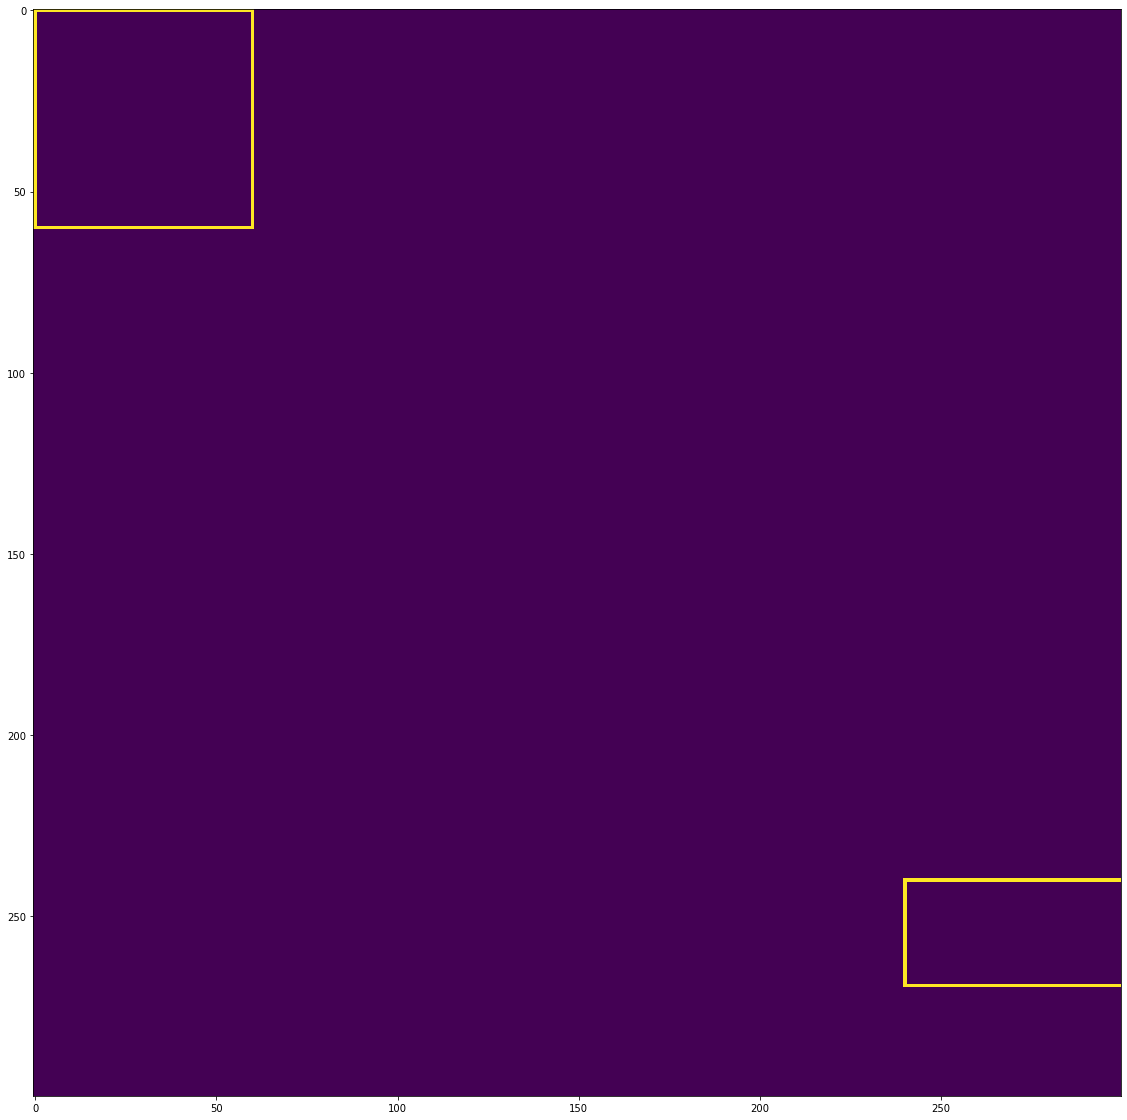

In [74]:
image_width = 300
image_height = 300
gt_color = (100, 100, 0)
color = (255, 0, 0)

image = np.ones((image_width, image_height))

# draw gt_boxes
for gt in gt_boxes[0,:,:]:
    start_x, start_y, end_x, end_y = gt.numpy()

    start_x, start_y, end_x, end_y = int(start_x * image_width), int(start_y * image_height), int(end_x * image_width), int(end_y * image_height)
#     print(start_x, start_y, end_x, end_y )
    image = cv2.rectangle(image, [start_x, start_y], [end_x, end_y], gt_color, thickness = 1)
    
# for m in tf.math.argmax(union, axis = 0):
#     start_x, start_y, end_x, end_y = boxes[m, :].numpy()
    
#     start_x, start_y, end_x, end_y = int(start_x * image_width), int(start_y * image_height), int(end_x * image_width), int(end_y * image_height)
    
#     image = cv2.rectangle(image, [start_x, start_y], [end_x, end_y], color, thickness = 1)
    
plt.figure(figsize = (20,20))
plt.imshow(image)

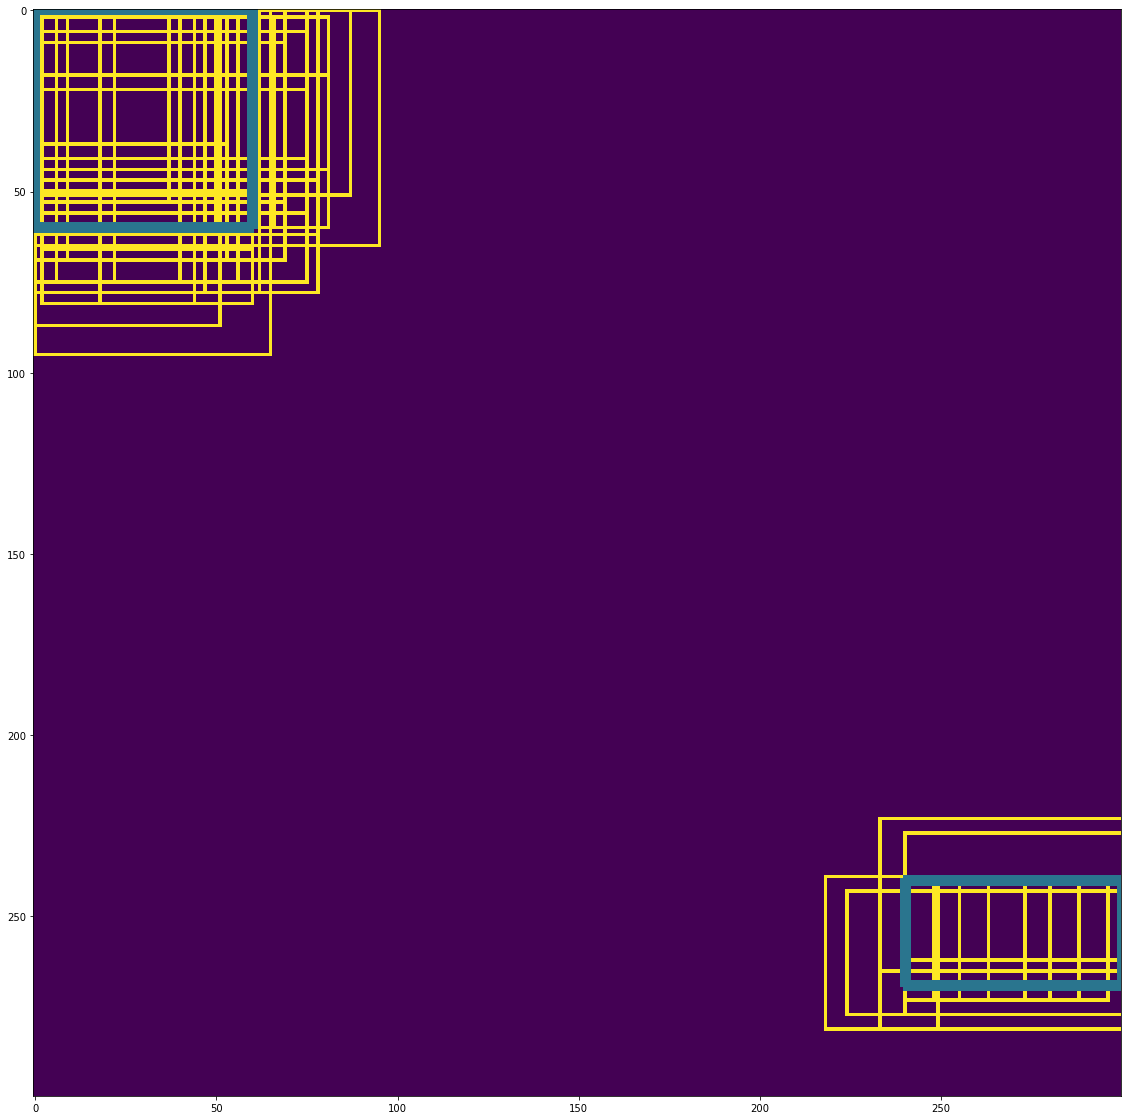

In [79]:
image_width = 300
image_height = 300
gt_color = (100, 100, 0)
color = (255, 0, 0)

image = np.ones((image_width, image_height))

i = 0
for gt in gt_boxes_map_to_prior[0,:,:]:
    start_x, start_y, end_x, end_y = gt.numpy()
    
    if (end_x - start_x) > 0 and (end_y - start_y) > 0:
        
        start_x, start_y, end_x, end_y = boxes[i, :].numpy()
    
        start_x, start_y, end_x, end_y = int(start_x * image_width), int(start_y * image_height), int(end_x * image_width), int(end_y * image_height)

        image = cv2.rectangle(image, [start_x, start_y], [end_x, end_y], color, thickness = 1)
    i+=1
    
# draw gt_boxes
for gt in gt_boxes[0,:,:]:
    start_x, start_y, end_x, end_y = gt.numpy()

    start_x, start_y, end_x, end_y = int(start_x * image_width), int(start_y * image_height), int(end_x * image_width), int(end_y * image_height)
#     print(start_x, start_y, end_x, end_y )
    image = cv2.rectangle(image, [start_x, start_y], [end_x, end_y], gt_color, thickness = 2)

    
plt.figure(figsize = (20,20))
plt.imshow(image)

In [ ]:
i = 0
for gt in gt_boxes_map_to_prior:
    start_x, start_y, end_x, end_y = gt.numpy()
    
    if (end_x - start_x) > 0 and (end_y - start_y) > 0:
        
        print(i, gt_labels_map_to_prior[i])
    i+=1

In [ ]:
gt_labels_map_to_prior

In [ ]:
labels = tf.one_hot(gt_labels_map_to_prior, 3)

In [91]:
tf.random.set_seed(
    420
)

In [104]:
tf.random.uniform(shape=(1, 1), minval=0, maxval=20, dtype=tf.int32)

<tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[4]], dtype=int32)>

In [99]:
actual_labels = tf.random.uniform(shape=(20, 8732, 20), minval=0, maxval=2, dtype=tf.int32)
actual_labels = tf.cast(actual_labels, tf.float32)

pred_labels = tf.random.uniform(shape=(20, 8732, 20), minval=0, maxval=2, dtype=tf.int32)
pred_labels = tf.cast(pred_labels, tf.float32)

In [100]:
conf_loss_fn = tf.losses.CategoricalCrossentropy(reduction=tf.losses.Reduction.NONE)
conf_loss_for_all = conf_loss_fn(actual_labels, pred_labels)

In [101]:
conf_loss_for_all

<tf.Tensor: shape=(20, 8732), dtype=float32, numpy=
array([[ 55.80901 ,  89.80082 , 100.46973 , ...,  88.22389 ,  47.14563 ,
         76.89691 ],
       [ 74.063965,  61.17903 ,  62.74166 , ..., 132.83658 ,  91.5766  ,
        128.94476 ],
       [ 90.530106, 101.31374 ,  78.85976 , ...,  92.1034  ,  70.018684,
         43.222313],
       ...,
       [111.61801 ,  92.10341 ,  82.89307 , ..., 108.69805 ,  78.85976 ,
        118.6644  ],
       [118.20195 , 129.63791 ,  73.682724, ...,  78.85976 ,  93.77382 ,
        100.86745 ],
       [ 45.776443,  71.38014 ,  48.48449 , ..., 124.33959 , 162.56726 ,
         84.991974]], dtype=float32)>